In [4]:
import pandas as pd
import plotly.express as px
import seaborn as sns

In [5]:
def preprocessing(df):
    col = []

    # Entferne redundante Bezeichnungen aus den Spaltennamen
    for x in df.columns:
        col.append(x.split(" ")[0])

    df.columns = col
    
    # Entferne alle Schritte mit StepID = 2, da diese für das Projekt nicht relevant sind
    df.drop(df[df["CuStepNo"] == 2].index, inplace = True)
    
    # Extrahiere die Zeitangaben bzw. formatiere die Zeitstempel in das richtige Format
    df.timestamp = pd.to_datetime(df.timestamp)


    df["day"] = df.timestamp.dt.day
    df["hour"] = df.timestamp.dt.hour
    df["second"] = df.timestamp.dt.second
    
    step_batch_df(df) # erstellt die  beiden Dateien, die im nächsten Schritt gelesen werden
    
    # Entferne einen Zeileneintrag, bei dem die DeviationID 0 ist
    # Entferne den letzten unvollständigen Batch aus dem Datensatz
    df_steps = pd.read_pickle("SmA-Four-Tank-Info-Steps.pkl")
    df_batches = pd.read_pickle("SmA-Four-Tank-Info-Batches.pkl")
    df = df.drop(df[df.timestamp >= '2018-10-31 14:29:32'].index)
    df = df.drop(df[df.DeviationID == 0].index)

In [6]:
def step_batch_df(df):
    # determine start and end of steps
    df['dstep_p']=df['CuStepNo'].diff()
    df['dstep_n']=df['CuStepNo'].diff(-1)

    vsteps = [1,7,8,3]

    # select rows with a step change
    dfsen=df[(df['dstep_n']!=0)]
    dfsep=df[(df['dstep_p']!=0)]
    dfse=pd.concat([dfsen,dfsep])
    dfse=dfse.sort_values(by=['timestamp'])

    # create new dataframe where we store extracted information
    dfinfo_steps=pd.DataFrame(columns=['step_length','start','end','stepn'])

    # iterative approach
    pstep=-1
    c=0
    for n in range(dfse.shape[0]):
        # get row
        r=dfse.iloc[n]
        if pstep==r['CuStepNo']:
            # determine step length
            stepl=r['timestamp']-dfse.iloc[n-1]['timestamp']
            # update dataframe
            dfinfo_steps.loc[c]=(stepl,dfse.iloc[n-1]['timestamp'],r['timestamp'],r['CuStepNo'])
            c=c+1
        else:
            pstep=r['CuStepNo']
    print(dfinfo_steps.head())
    print('Max step_length: {}'.format(dfinfo_steps['step_length'].max()))
    print('Min step_length: {}'.format(dfinfo_steps['step_length'].min()))
    print('#steps: {}'.format(dfinfo_steps.shape[0]))

    # now determine whether the batch is complete
    batchn=1
    batchi=-1
    dfinfo_steps["batchn"]=0
    dfinfo_steps["is_complete"]=False
    dfinfo_batches=pd.DataFrame(columns=['batch_length','start','end','steps','batchn','is_complete'])
    n=0
    b=0
    while True:
        if n+len(vsteps)>dfinfo_steps.shape[0]:
            # complete info at incomplete, last batch
            steps=[]
            for v in range(dfinfo_steps.shape[0]-n):
                dfinfo_steps.at[n+v,'batchn']=batchi
                dfinfo_steps.at[n+v,'is_complete']=False
                steps.append(dfinfo_steps.at[n+v,'stepn'])
            dfinfo_batches.loc[b]=[dfinfo_steps.at[n+v,'end']-dfinfo_steps.at[n,'start'],dfinfo_steps.at[n,'start'], \
                                   dfinfo_steps.at[n+v,'end'],steps,batchi,False]
            b=b+1
            break
        # check if all steps of a batch are present and in correct order
        isCorrect=True
        for v in range(len(vsteps)):
            isCorrect=dfinfo_steps.loc[n+v,'stepn']==vsteps[v]
            if not isCorrect:
                break
        if isCorrect:
            steps=[]
            for v in range(len(vsteps)):
                dfinfo_steps.at[n+v,'batchn']=batchn
                dfinfo_steps.at[n+v,'is_complete']=True
                steps.append(dfinfo_steps.at[n+v,'stepn'])
            dfinfo_batches.loc[b]=[dfinfo_steps.at[n+v,'end']-dfinfo_steps.at[n,'start'],dfinfo_steps.at[n,'start'], \
                                   dfinfo_steps.at[n+v,'end'],steps,batchn,True]
            n=n+len(vsteps)
            batchn=batchn+1
            b=b+1
        else:
            steps=[]
            for vc in range(v):
                dfinfo_steps.at[n+vc,'batchn']=batchi
                dfinfo_steps.at[n+vc,'is_complete']=False
                steps.append(dfinfo_steps.at[n+v,'stepn'])
            dfinfo_batches.loc[b]=[dfinfo_steps.at[n+vc,'end']-dfinfo_steps.at[n,'start'],dfinfo_steps.at[n,'start'], \
                                   dfinfo_steps.at[n+vc,'end'],steps,batchi,False]
            batchi=batchi-1
            n=n+vc
            b=b+1
            
    # save dfinfo_steps to file
    dfinfo_steps.to_pickle('SmA-Four-Tank-Info-Steps.pkl')
    dfinfo_batches.to_pickle('SmA-Four-Tank-Info-Batches.pkl')
    
    # Füge Batchnummern und Schrittlängen zum Dataframe hinzu
    a = df.merge(df_steps, how = "left", left_on = "timestamp", right_on = "start")
    a[["stepn"]] = a[["stepn"]].fillna(method = "ffill")
    a[["batchn"]] = a[["batchn"]].fillna(method = "ffill")
    a["step_length"] = a["step_length"].dt.total_seconds()
    a[["step_length"]] = a[["step_length"]].fillna(0)
    # redundante oder unnötige Spalten entfernen
    a.drop(columns = ["start", "end", "is_complete", "stepn"], inplace = True)

    useless_columns = []

    for x in a.columns[1:]:
        if a[x].describe()[2] == 0.0 and a[x].describe()[3] == a[x].describe()[-1]:
            print(x)
            useless_columns.append(x)
            print(f"unique values: {a[x].unique()}")

    a.drop(columns = useless_columns, inplace = True)
    a.drop(["PIC14007_SP"], axis = 1, inplace = True)

    # Erstelle neue Spalte timestamp_difference, die den Zeitunterschied seit dem vorherigen Datenpunkt in Sekunden anzeigt.

    a["timestamp_difference"] = a.timestamp.diff().dt.total_seconds()

    # Setze den Wert der zuvor erstellten Spalte bei jedem neuen Batch zu Beginn auf 0

    a.loc[a.timestamp_difference > 80, "timestamp_difference"] = 0
    a.loc[0, "timestamp_difference"] = 0

    # Erstelle neue Spalte batch_duration, die pro Batch die gesamt verstrichene Zeit seit Batchbeginn anzeigt.


    a["batch_duration"] = 0

    for x in range(1, a.batchn.nunique() + 1):
        # Pro Batchnummer wird die Batchzeit berechnet (sonst bekommt man am Ende die Gesamtdauer aller Batches)
        a.loc[a.batchn == x, "batch_duration"] = a.loc[a.batchn == x, :].timestamp_difference.cumsum()

    for x in range(1, a.batchn.nunique() + 1):
        for i in a[a.batchn == x].CuStepNo.unique():
            a.loc[(a.batchn == x) & (a.CuStepNo == i), "step_length"] = a.loc[(a.batchn == x) & (a.CuStepNo == i), :].timestamp_difference.cumsum()


In [7]:
df = pd.read_csv("C:/Users/danie/Downloads/SmA-Four-Tank-Batch-Process_V2.csv", sep = ";")

In [8]:
col = []

# Entferne redundante Bezeichnungen aus den Spaltennamen
for x in df.columns:
    col.append(x.split(" ")[0])
    
df.columns = col

In [9]:
# Entferne alle Schritte mit StepID = 2, da diese für das Projekt nicht relevant sind
df.drop(df[df["CuStepNo"] == 2].index, inplace = True)

In [10]:
# Extrahiere die Zeitangaben bzw. formatiere die Zeitstempel in das richtige Format
df.timestamp = pd.to_datetime(df.timestamp)


df["day"] = df.timestamp.dt.day
df["hour"] = df.timestamp.dt.hour
df["second"] = df.timestamp.dt.second

In [11]:
# Keine NaN-Werte vorhanden
df[df.any(axis = 1).isna()]

,timestamp,DeviationID,CuStepNo,LevelMainTank,YC10001_MV,PI12002_PV_Out,PI12003_PV_Out,YC14001_MV,FIC14002_MV,FIC14002_PV_Out,...,LIC21002_PV_Out,LIC21002_SP,PIC14007_MV,PIC14007_PV_Out,PIC14007_SP,YC14008_Ctrl,PI10003_PV_Out,day,hour,second


In [12]:
# determine start and end of steps
df['dstep_p']=df['CuStepNo'].diff()
df['dstep_n']=df['CuStepNo'].diff(-1)

vsteps = [1,7,8,3]

# select rows with a step change
dfsen=df[(df['dstep_n']!=0)]
dfsep=df[(df['dstep_p']!=0)]
dfse=pd.concat([dfsen,dfsep])
dfse=dfse.sort_values(by=['timestamp'])

# create new dataframe where we store extracted information
dfinfo_steps=pd.DataFrame(columns=['step_length','start','end','stepn'])

# iterative approach
pstep=-1
c=0
for n in range(dfse.shape[0]):
    # get row
    r=dfse.iloc[n]
    if pstep==r['CuStepNo']:
        # determine step length
        stepl=r['timestamp']-dfse.iloc[n-1]['timestamp']
        # update dataframe
        dfinfo_steps.loc[c]=(stepl,dfse.iloc[n-1]['timestamp'],r['timestamp'],r['CuStepNo'])
        c=c+1
    else:
        pstep=r['CuStepNo']
print(dfinfo_steps.head())
print('Max step_length: {}'.format(dfinfo_steps['step_length'].max()))
print('Min step_length: {}'.format(dfinfo_steps['step_length'].min()))
print('#steps: {}'.format(dfinfo_steps.shape[0]))

# now determine whether the batch is complete
batchn=1
batchi=-1
dfinfo_steps["batchn"]=0
dfinfo_steps["is_complete"]=False
dfinfo_batches=pd.DataFrame(columns=['batch_length','start','end','steps','batchn','is_complete'])
n=0
b=0
while True:
    if n+len(vsteps)>dfinfo_steps.shape[0]:
        # complete info at incomplete, last batch
        steps=[]
        for v in range(dfinfo_steps.shape[0]-n):
            dfinfo_steps.at[n+v,'batchn']=batchi
            dfinfo_steps.at[n+v,'is_complete']=False
            steps.append(dfinfo_steps.at[n+v,'stepn'])
        dfinfo_batches.loc[b]=[dfinfo_steps.at[n+v,'end']-dfinfo_steps.at[n,'start'],dfinfo_steps.at[n,'start'], \
                               dfinfo_steps.at[n+v,'end'],steps,batchi,False]
        b=b+1
        break
    # check if all steps of a batch are present and in correct order
    isCorrect=True
    for v in range(len(vsteps)):
        isCorrect=dfinfo_steps.loc[n+v,'stepn']==vsteps[v]
        if not isCorrect:
            break
    if isCorrect:
        steps=[]
        for v in range(len(vsteps)):
            dfinfo_steps.at[n+v,'batchn']=batchn
            dfinfo_steps.at[n+v,'is_complete']=True
            steps.append(dfinfo_steps.at[n+v,'stepn'])
        dfinfo_batches.loc[b]=[dfinfo_steps.at[n+v,'end']-dfinfo_steps.at[n,'start'],dfinfo_steps.at[n,'start'], \
                               dfinfo_steps.at[n+v,'end'],steps,batchn,True]
        n=n+len(vsteps)
        batchn=batchn+1
        b=b+1
    else:
        steps=[]
        for vc in range(v):
            dfinfo_steps.at[n+vc,'batchn']=batchi
            dfinfo_steps.at[n+vc,'is_complete']=False
            steps.append(dfinfo_steps.at[n+v,'stepn'])
        dfinfo_batches.loc[b]=[dfinfo_steps.at[n+vc,'end']-dfinfo_steps.at[n,'start'],dfinfo_steps.at[n,'start'], \
                               dfinfo_steps.at[n+vc,'end'],steps,batchi,False]
        batchi=batchi-1
        n=n+vc
        b=b+1
# save dfinfo_steps to file
dfinfo_steps.to_pickle('SmA-Four-Tank-Info-Steps.pkl')
dfinfo_batches.to_pickle('SmA-Four-Tank-Info-Batches.pkl')


      step_length               start                 end stepn
0 0 days 00:04:07 2018-10-10 14:53:19 2018-10-10 14:57:26     1
1 0 days 00:01:12 2018-10-10 14:57:27 2018-10-10 14:58:39     7
2 0 days 00:08:52 2018-10-10 14:58:40 2018-10-10 15:07:32     8
3 0 days 00:03:17 2018-10-10 15:07:33 2018-10-10 15:10:50     3
4 0 days 00:04:08 2018-10-11 10:21:45 2018-10-11 10:25:53     1
Max step_length: 0 days 00:24:25
Min step_length: 0 days 00:00:04
#steps: 1047


In [13]:
df_steps = pd.read_pickle("C:/Users/danie/SmA-Four-Tank-Info-Steps.pkl")
df_batches = pd.read_pickle("C:/Users/danie/SmA-Four-Tank-Info-Batches.pkl")

In [14]:
# Entferne den letzten unvollständigen Batch aus dem Datensatz

df = df.drop(df[df.timestamp >= '2018-10-31 14:29:32'].index)

In [15]:
df[df.DeviationID == 0]

,timestamp,DeviationID,CuStepNo,LevelMainTank,YC10001_MV,PI12002_PV_Out,PI12003_PV_Out,YC14001_MV,FIC14002_MV,FIC14002_PV_Out,...,PIC14007_MV,PIC14007_PV_Out,PIC14007_SP,YC14008_Ctrl,PI10003_PV_Out,day,hour,second,dstep_p,dstep_n
253156,2018-10-30 10:22:24,0,3,99.083115,100,0.056134,0.065972,100.0,100.0,0.0,...,10.0,0.119471,0.2,0,0.001749,30,10,24,0.0,2.0


In [16]:
# Entferne einen Zeileneintrag, bei dem die DeviationID 0 ist

df = df.drop(df[df.DeviationID == 0].index)

# DevId
### 1 --> Pl1200 (zwischen PL12002 und PL12003)
### 2 --> PL1100 (zwischen YC10001 und YC14001)
### 3 --> YC21006
### 4 --> YC22006
### 5 --> YC23006
### 6 --> YS14005
### 7 --> Pl2150
### 8 --> YS14004
### 9 --> YS10004

Schritt 7 generell am kürzesten, Schritt 8 am längsten (evtl. wegen Pausen zwischen den Batches? An Wochenenden wurden jedoch keine Daten gespeichert)

In [17]:
df.groupby("CuStepNo").agg({"second":"sum"})

,second
CuStepNo,
1,1965652
3,1517149
7,545171
8,4129438


In [18]:
df_steps.groupby("stepn").agg({"step_length":"sum"})

,step_length
stepn,
1,0 days 18:30:27
3,0 days 14:14:25
7,0 days 05:06:07
8,1 days 15:13:13


In [19]:
# Füge Batchnummern und Schrittlängen zum Dataframe hinzu
a = df.merge(df_steps, how = "left", left_on = "timestamp", right_on = "start")

In [20]:
a[["stepn"]] = a[["stepn"]].fillna(method = "ffill")
a[["batchn"]] = a[["batchn"]].fillna(method = "ffill")
a["step_length"] = a["step_length"].dt.total_seconds()
a[["step_length"]] = a[["step_length"]].fillna(0)

In [21]:
# redundante oder unnötige Spalten entfernen
a.drop(columns = ["start", "end", "is_complete", "stepn"], inplace = True)

## Ein Batchprozess benötigt hier zwischen 468 und 1997 Sekunden.

In [22]:
a.groupby(["batchn"]).agg({"timestamp":"count", "DeviationID":"unique", "CuStepNo":"unique"}).sort_values("timestamp")

,timestamp,DeviationID,CuStepNo
batchn,,,
9.0,468,[9],"[1, 7, 8, 3]"
142.0,490,[6],"[1, 7, 8, 3]"
22.0,700,[1],"[1, 7, 8, 3]"
255.0,944,[1],"[1, 7, 8, 3]"
164.0,986,[7],"[1, 7, 8, 3]"
...,...,...,...
149.0,1120,[6],"[1, 7, 8, 3]"
145.0,1120,[6],"[1, 7, 8, 3]"
146.0,1124,[6],"[1, 7, 8, 3]"


### Schritt 8 in Batch 9 äußerst kurz

In [23]:
a[a.batchn == 9].drop_duplicates(subset = ["step_length"])

,timestamp,DeviationID,CuStepNo,LevelMainTank,YC10001_MV,PI12002_PV_Out,PI12003_PV_Out,YC14001_MV,FIC14002_MV,FIC14002_PV_Out,...,PIC14007_SP,YC14008_Ctrl,PI10003_PV_Out,day,hour,second,dstep_p,dstep_n,step_length,batchn
8449,2018-10-11 14:25:06,9,1,144.339996,100,0.074653,0.090278,100.000000,100.000000,0.000000,...,0.2,0,0.001648,11,14,6,-2.0,0.0,304.0,9.0
8450,2018-10-11 14:25:07,9,1,144.388336,100,0.072917,0.092014,100.000000,100.000000,0.000000,...,0.2,0,0.001653,11,14,7,0.0,0.0,0.0,9.0
8754,2018-10-11 14:30:11,9,7,130.546753,100,0.068287,1.629630,56.737617,56.677292,2021.886108,...,0.2,0,0.001662,11,14,11,6.0,0.0,52.0,9.0
8807,2018-10-11 14:31:04,9,8,133.906860,100,0.065972,1.663194,57.214474,57.215546,1994.629639,...,0.2,0,0.001721,11,14,4,1.0,0.0,4.0,9.0
8812,2018-10-11 14:31:09,9,3,134.949493,100,0.062500,1.475694,55.968204,55.935966,2161.196045,...,0.2,0,0.001677,11,14,9,-5.0,0.0,104.0,9.0


In [24]:
a.groupby("DeviationID").agg({"batchn":"nunique"})

,batchn
DeviationID,
1,35
2,24
3,25
4,23
5,24
6,24
7,24
8,24
9,35


In [25]:
a.groupby("day").agg({"batchn":"nunique"})

,batchn
day,
10,1
11,8
12,11
15,5
16,28
17,23
18,23
19,20
22,22


### Bei 9 Spalten sind die gemessenene Werte konstant

--> nicht nützlich zur Anomaliedetektion/ Klassifizierung, kann entfernt werden

In [26]:
useless_columns = []

for x in a.columns[1:]:
    if a[x].describe()[2] == 0.0 and a[x].describe()[3] == a[x].describe()[-1]:
        print(x)
        useless_columns.append(x)
        print(f"unique values: {a[x].unique()}")
        
a.drop(columns = useless_columns, inplace = True)

YC10001_MV
unique values: [100]
YC22001_MV
unique values: [0]
FIC22002_MV
unique values: [0]
YS23004_Ctrl
unique values: [0]
YS22004_Ctrl
unique values: [0]
YS21004_Ctrl
unique values: [0]
LIC22002_SP
unique values: [2]
LIC21002_SP
unique values: [15]
YC14008_Ctrl
unique values: [0]


Die Werte in PIC14007_SP weisen keine signifikant großen Veränderungen auf

In [27]:
a.drop(["PIC14007_SP"], axis = 1, inplace = True)

In [28]:
a["DeviationID"] = a.DeviationID.astype(float)

In [29]:
# Erstelle neue Spalte timestamp_difference, die den Zeitunterschied seit dem vorherigen Datenpunkt in Sekunden anzeigt.

a["timestamp_difference"] = a.timestamp.diff().dt.total_seconds()

In [30]:
# Setze den Wert der zuvor erstellten Spalte bei jedem neuen Batch zu Beginn auf 0

a.loc[a.timestamp_difference > 80, "timestamp_difference"] = 0
a.loc[0, "timestamp_difference"] = 0

In [31]:
# Erstelle neue Spalte batch_duration, die pro Batch die gesamt verstrichene Zeit seit Batchbeginn anzeigt.


a["batch_duration"] = 0

for x in range(1, a.batchn.nunique() + 1):
    # Pro Batchnummer wird die Batchzeit berechnet (sonst bekommt man am Ende die Gesamtdauer aller Batches)
    a.loc[a.batchn == x, "batch_duration"] = a.loc[a.batchn == x, :].timestamp_difference.cumsum()

In [32]:
for x in range(1, a.batchn.nunique() + 1):
    for i in a[a.batchn == x].CuStepNo.unique():
        a.loc[(a.batchn == x) & (a.CuStepNo == i), "step_length"] = a.loc[(a.batchn == x) & (a.CuStepNo == i), :].timestamp_difference.cumsum()

## Dynamic Time Warping

In [33]:
import fastdtw.fastdtw
# fastdtw 0.3.4
import pandas as pd

In [34]:
a_dtw = a.drop(["timestamp", "day", "hour", "second", "dstep_p", "dstep_n",
               "timestamp_difference"], axis = 1)

In [51]:
import numpy as np
from tslearn.metrics import dtw_path, dtw, dtw_path_from_metric

# dtw_df soll die neuen Zeitreihen beinhalten
dtw_df = pd.DataFrame(columns=a_dtw.columns)

dtw_series_list = []

g = []

# Gehe über jedes Feature
for col in a_dtw.columns:
    print(col)

    dtw_series = []

    for x in a_dtw.CuStepNo.unique():
        # Datensatz mit nur diesem Schritt
        step_df = a_dtw[a_dtw.CuStepNo == x]

        # Schrittdauer für angepasste neue Zeitserien ermitteln
        max_length = int(a_dtw[a_dtw.CuStepNo == x].step_length.median())
                         #+ 1.96 * a_dtw[a_dtw.CuStepNo == x].step_length.std())
        
        for b in a_dtw.batchn.unique():
            
            time_series = step_df[step_df.batchn == b][col].to_numpy()

            # DTW, um alte Zeitreihe an die neue Größe anzupassen (Berechnen der Distanzmatrizen)
            distance, path = fastdtw.fastdtw(time_series, np.ones(max_length))

            # Neue Zeitreihe, die dann in dtw_df übernommen wird
            new_time_series = np.zeros(max_length)

            # Ersetze die Nullen durch die Werte aus den alten Zeitreihen (beide haben die gleiche Länge)
            for i, j in path:
                    new_time_series[j] = time_series[i]
                
            if col == "PI12002_PV_Out" and b == 255:
                g = dist

            # Werte an dtw_series ranhängen
            dtw_series.append(new_time_series)
    
    # enthält alle bisher aufgenommenen Daten, könnte für einen effizienteren Algorithmus angepasst werden
    dtw_series_list.append(dtw_series)

# Für jedes Feature und jeden Schritt werden die Werte aus dtw_series zu dtw_df hinzugefügt, and add them to the new DataFrame
for i, col in enumerate(a_dtw.columns):
    dtw_df[col] = pd.concat([pd.Series(batch) for batch in dtw_series_list[i]])

DeviationID
CuStepNo
LevelMainTank
PI12002_PV_Out
PI12003_PV_Out
YC14001_MV
FIC14002_MV
FIC14002_PV_Out
FIC14002_SP
YC14006_MV
PI14012_PV_Out
YC23001_MV
YC21001_MV
FIC23002_PV_Out
FIC23002_MV
FIC23002_SP
FIC22002_PV_Out
FIC22002_SP
FIC21002_MV
FIC21002_PV_Out
FIC21002_SP
LIC23002_MV
LIC23002_PV_Out
LIC23002_SP
LIC22002_MV
LIC22002_PV_Out
LIC21002_MV
LIC21002_PV_Out
PIC14007_MV
PIC14007_PV_Out
PI10003_PV_Out
step_length
batchn
batch_duration


In [50]:
path

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (1, 17),
 (2, 18),
 (3, 19),
 (4, 20),
 (5, 21),
 (6, 22),
 (7, 23),
 (8, 24),
 (9, 25),
 (10, 26),
 (11, 27),
 (12, 28),
 (13, 29),
 (14, 30),
 (15, 31),
 (16, 32),
 (17, 33),
 (18, 34),
 (19, 35),
 (20, 36),
 (21, 37),
 (22, 38),
 (23, 39),
 (24, 40),
 (25, 41),
 (26, 42),
 (27, 43),
 (28, 44),
 (29, 45),
 (30, 46),
 (31, 47),
 (32, 48),
 (33, 49),
 (34, 50),
 (35, 51),
 (36, 52),
 (37, 53),
 (38, 54),
 (39, 55),
 (40, 56),
 (41, 57),
 (42, 58),
 (43, 59),
 (44, 60),
 (45, 61),
 (46, 62),
 (47, 63),
 (48, 64),
 (49, 65),
 (50, 66),
 (51, 67),
 (52, 68),
 (53, 69),
 (54, 70),
 (55, 71),
 (56, 72),
 (57, 73),
 (58, 74),
 (59, 75),
 (60, 76),
 (61, 77),
 (62, 78),
 (63, 79),
 (64, 80),
 (65, 81),
 (66, 82),
 (67, 83),
 (68, 84),
 (69, 85),
 (70, 86),
 (71, 87),
 (72, 88),
 (73, 89),
 (74, 90),
 (75, 91),
 (76, 92),
 (77, 93),
 (

In [1312]:
g

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0),
 (10, 0),
 (11, 0),
 (12, 0),
 (13, 0),
 (14, 0),
 (15, 0),
 (16, 0),
 (17, 0),
 (18, 0),
 (19, 0),
 (20, 0),
 (21, 0),
 (22, 0),
 (23, 0),
 (24, 0),
 (25, 0),
 (26, 0),
 (27, 0),
 (28, 0),
 (29, 0),
 (30, 0),
 (31, 0),
 (32, 0),
 (33, 0),
 (34, 0),
 (35, 0),
 (36, 0),
 (37, 0),
 (38, 0),
 (39, 0),
 (40, 0),
 (41, 0),
 (42, 0),
 (43, 0),
 (44, 0),
 (45, 0),
 (46, 0),
 (47, 0),
 (48, 0),
 (49, 0),
 (50, 0),
 (51, 0),
 (52, 0),
 (53, 0),
 (54, 0),
 (55, 0),
 (56, 0),
 (57, 0),
 (58, 0),
 (59, 0),
 (60, 0),
 (61, 0),
 (62, 0),
 (63, 0),
 (64, 0),
 (65, 0),
 (66, 0),
 (67, 0),
 (68, 0),
 (69, 0),
 (70, 0),
 (71, 0),
 (72, 0),
 (73, 0),
 (74, 0),
 (75, 0),
 (76, 0),
 (77, 0),
 (78, 0),
 (79, 0),
 (80, 0),
 (81, 0),
 (82, 0),
 (83, 0),
 (84, 0),
 (85, 0),
 (86, 0),
 (87, 0),
 (88, 0),
 (89, 0),
 (90, 0),
 (91, 0),
 (92, 0),
 (93, 0),
 (94, 0),
 (95, 0),
 (96, 0),
 (97, 0),
 (98, 1),
 (99, 2),
 (100, 3),

In [52]:
# Zeitunterschied zwischen den interpolierten Zeilen

dtw_df["timestamp_difference"] = 1

# Erstelle die Werte für step_length wie zuvor beim DataFrame a

for x in range(1, dtw_df.batchn.nunique() + 1):
    for i in dtw_df[dtw_df.batchn == x].CuStepNo.unique():
        dtw_df.loc[(dtw_df.batchn == x) & (dtw_df.CuStepNo == i), "step_length"] = dtw_df.loc[(dtw_df.batchn == x) & (dtw_df.CuStepNo == i), :].timestamp_difference.cumsum()
        
# Spalte kann wieder entfernt werden, da nicht mehr benötigt
dtw_df.drop("timestamp_difference", axis = 1, inplace = True)

In [57]:
import pickle

dtw_df.to_pickle("df_app_ml_ready.pkl")

## Machine Learning

In [56]:
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler



In [1316]:
import pandas as pd

dtw_df = pd.read_pickle("df_app_ml_ready.pkl")

In [58]:
dtw_df.columns

Index(['DeviationID', 'CuStepNo', 'LevelMainTank', 'PI12002_PV_Out',
       'PI12003_PV_Out', 'YC14001_MV', 'FIC14002_MV', 'FIC14002_PV_Out',
       'FIC14002_SP', 'YC14006_MV', 'PI14012_PV_Out', 'YC23001_MV',
       'YC21001_MV', 'FIC23002_PV_Out', 'FIC23002_MV', 'FIC23002_SP',
       'FIC22002_PV_Out', 'FIC22002_SP', 'FIC21002_MV', 'FIC21002_PV_Out',
       'FIC21002_SP', 'LIC23002_MV', 'LIC23002_PV_Out', 'LIC23002_SP',
       'LIC22002_MV', 'LIC22002_PV_Out', 'LIC21002_MV', 'LIC21002_PV_Out',
       'PIC14007_MV', 'PIC14007_PV_Out', 'PI10003_PV_Out', 'step_length',
       'batchn', 'batch_duration'],
      dtype='object')

In [59]:
dtw_df.drop("batch_duration", axis = 1, inplace = True)

Training - Test - Split basierend auf Schrittgröße

In [60]:
from sklearn.model_selection import train_test_split

# beinhaltet jeden Schritt eines Batches jeweils nur einmal
only_batch_and_step = dtw_df.drop_duplicates(["batchn", "CuStepNo"])

train_steps = pd.DataFrame(columns = only_batch_and_step.columns)
test_steps = pd.DataFrame(columns = only_batch_and_step.columns)

# Führe einen Train-Test-Split pro DevID auf den Trainingsdaten aus
for devid in only_batch_and_step.DeviationID.unique():
    df_devid = only_batch_and_step[only_batch_and_step.DeviationID == devid]
    train_split, test_split = train_test_split(df_devid, test_size = 0.25, random_state = 42)

    train_steps = train_steps.append(train_split)
    test_steps = test_steps.append(test_split)
    

In [61]:
# Fülle Trainings- und Testdaten mit den anderen Daten, die für only_batch_and_step entfernt wurden


train_steps = train_steps[["batchn", "CuStepNo"]].merge(dtw_df, on = ["batchn", "CuStepNo"])
test_steps = test_steps[["batchn", "CuStepNo"]].merge(dtw_df, on = ["batchn", "CuStepNo"])

In [62]:
y_train_steps = train_steps.pop("DeviationID")
y_test_steps = test_steps.pop("DeviationID")

X_train_steps = train_steps.drop(["batchn", "CuStepNo"], axis = 1)
X_test_steps = test_steps.drop(["batchn", "CuStepNo"], axis = 1)

In [63]:
sc_steps = StandardScaler()
X_train_steps_sc = sc_steps.fit_transform(X_train_steps)
X_test_steps_sc = sc_steps.transform(X_test_steps)

Funktionen für Evaluieren und Speichern der Modelle

In [64]:
# Erstelle DataFrame, mit dem richtige und falsche Vorhersagen genauer untersucht werden können

def create_eval_df(test_df, pred, real):
    predicted_df = pd.DataFrame({"pred":pred, "real":real, "step": test_df["CuStepNo"], "batchn": test_df["batchn"],
                            "time": test_df["step_length"]})
    predicted_df["correct"] = predicted_df.real == predicted_df.pred
    return predicted_df

In [65]:
def save_model(model_name, model_file_name):

    if model_file_name.split(".")[-1] == "pkl":
        with open(model_file_name, "wb") as file:
            pickle.dump(model_name, file)
    else:
        print("file name has to end with .pkl")

### KNN (pyts, Time Series Classification)

In [103]:
X_train_steps.columns

Index(['LevelMainTank', 'PI12002_PV_Out', 'PI12003_PV_Out', 'YC14001_MV',
       'FIC14002_MV', 'FIC14002_PV_Out', 'FIC14002_SP', 'YC14006_MV',
       'PI14012_PV_Out', 'YC23001_MV', 'YC21001_MV', 'FIC23002_PV_Out',
       'FIC23002_MV', 'FIC23002_SP', 'FIC22002_PV_Out', 'FIC22002_SP',
       'FIC21002_MV', 'FIC21002_PV_Out', 'FIC21002_SP', 'LIC23002_MV',
       'LIC23002_PV_Out', 'LIC23002_SP', 'LIC22002_MV', 'LIC22002_PV_Out',
       'LIC21002_MV', 'LIC21002_PV_Out', 'PIC14007_MV', 'PIC14007_PV_Out',
       'PI10003_PV_Out', 'step_length'],
      dtype='object')

In [106]:
from pyts.classification import KNeighborsClassifier as pyts_KNN
import time
import pickle



start = time.time()
pyts_knn = pyts_KNN(n_neighbors = 10)
pyts_knn.fit(X_train_steps_sc, y_train_steps)
print(pyts_knn.score(X_test_steps_sc, y_test_steps))
end = time.time()

print(end - start)

0.7688070080375689
5.111020088195801


In [1641]:
save_model(pyts_KNN, "pyts_KNN.pkl")

In [1642]:
pickled_model = pickle.load(open('pyts_KNN.pkl', 'rb'))

In [107]:
pred = pyts_knn.predict(X_test_steps_sc)
eval_knn = pd.DataFrame({"pred":pred, "true":y_test_steps})
eval_knn

,pred,true
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
33214,10.0,10.0
33215,10.0,10.0
33216,9.0,10.0
33217,7.0,10.0


In [108]:
eval_knn["correct"] = eval_knn.pred == eval_knn.true

In [109]:
pd.DataFrame.from_dict(classification_report(y_pred = eval_knn.pred, y_true = eval_knn.true, output_dict = True)).round(4)

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,accuracy,macro avg,weighted avg
precision,0.5790,0.9235,0.8681,0.8321,0.6671,0.8099,0.7833,1.0000,0.6822,0.6691,0.7688,0.7814,0.7700
recall,0.6983,0.9716,0.8831,0.8220,0.4919,0.7982,0.7907,0.9879,0.7801,0.4951,0.7688,0.7719,0.7688
f1-score,0.6331,0.9470,0.8755,0.8270,0.5662,0.8040,0.7870,0.9939,0.7279,0.5691,0.7688,0.7731,0.7657
support,4293.0000,3068.0000,3011.0000,3141.0000,3068.0000,3068.0000,3068.0000,3068.0000,4293.0000,3141.0000,0.7688,33219.0000,33219.0000


In [110]:
eval_knn[eval_knn.true == 1].groupby(["true", "pred"]).count()

correct
true pred         
1.0  1.0      2998
     2.0       127
     3.0        99
     4.0       208
     5.0       507
     6.0       103
     7.0        18
     9.0       206
     10.0       27

In [111]:
eval_knn[(eval_knn.true == 1) & (eval_knn.pred == 2)]

,pred,true,correct
6,2.0,1.0,False
7,2.0,1.0,False
13,2.0,1.0,False
14,2.0,1.0,False
15,2.0,1.0,False
...,...,...,...
3487,2.0,1.0,False
3499,2.0,1.0,False
3504,2.0,1.0,False
3628,2.0,1.0,False


### ROCKET mit RidgeClassifier (skaliert)

In [1683]:
from sklearn.linear_model import RidgeClassifierCV, SGDClassifier
from sklearn.model_selection import GridSearchCV
import time
from pyts.transformation import ROCKET

In [1693]:
rocket = ROCKET(n_kernels= 1000, random_state = 42)
start = time.time()
X_train_rocket = rocket.fit_transform(X_train_steps_sc, y_train_steps)
end = time.time()

print(f"Trainingszeit: {end - start} Sekunden")

Trainingszeit: 68.02310061454773 Sekunden


In [1694]:
rcf = RidgeClassifierCV(alphas = [0.001], cv = 3)
start = time.time()
rcf.fit(X_train_rocket, y_train_steps)
end = time.time()
print(f"Trainingszeit auf RCF: {end - start} Sekunden")

Trainingszeit auf RCF: 21.331284761428833 Sekunden


In [1695]:
X_test_rocket = rocket.transform(X_test_steps_sc)

In [1696]:
rcf.score(X_test_rocket, y_test_steps)

0.8151058129383787

In [1697]:
# Speichere die Modelle für den späteren Gebrauch
save_model(rocket, "ROCKET_unscaled.pkl")
save_model(rcf, "Classifier_for_ROCKET_unscaled.pkl")

In [1698]:
y_pred_rocket = rcf.predict(X_test_rocket)

eval_rocket = pd.DataFrame({"pred": y_pred_rocket, "real":y_test_steps}).reset_index()

rocket_report = classification_report(y_true = y_test_steps, y_pred = y_pred_rocket,
                      output_dict = True
                     )

rocket_report = pd.DataFrame.from_dict(rocket_report).round(4)

rocket_report

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,accuracy,macro avg,weighted avg
precision,0.6814,0.8633,0.9052,0.9514,0.6910,0.9125,0.8368,1.0000,0.7223,0.6982,0.8151,0.8262,0.8169
recall,0.6935,0.9945,0.8625,0.8656,0.7200,0.8393,0.8507,0.9977,0.8258,0.5517,0.8151,0.8201,0.8151
f1-score,0.6874,0.9243,0.8833,0.9065,0.7052,0.8744,0.8437,0.9989,0.7706,0.6164,0.8151,0.8211,0.8139
support,4293.0000,3068.0000,3011.0000,3141.0000,3068.0000,3068.0000,3068.0000,3068.0000,4293.0000,3141.0000,0.8151,33219.0000,33219.0000


In [1699]:
eval_rocket["correct"] = eval_rocket.pred == eval_rocket.real

Testdaten aus dem Normalzustand werden bei false positives am häufigsten der DeviationID 10 zugewiesen

In [1899]:
eval_rocket[(eval_rocket.real == 1)].groupby("pred").count()

,index,real,correct
pred,,,
1.0,2977,2977,2977
2.0,322,322,322
3.0,89,89,89
4.0,44,44,44
5.0,554,554,554
6.0,26,26,26
7.0,13,13,13
9.0,205,205,205
10.0,63,63,63


In [1701]:
rocket_report = classification_report(y_true = eval_rocket.real, y_pred = eval_rocket.pred,
                      output_dict = True
                     )

rocket_report = pd.DataFrame.from_dict(rocket_report).round(4)

rocket_report

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,accuracy,macro avg,weighted avg
precision,0.6814,0.8633,0.9052,0.9514,0.6910,0.9125,0.8368,1.0000,0.7223,0.6982,0.8151,0.8262,0.8169
recall,0.6935,0.9945,0.8625,0.8656,0.7200,0.8393,0.8507,0.9977,0.8258,0.5517,0.8151,0.8201,0.8151
f1-score,0.6874,0.9243,0.8833,0.9065,0.7052,0.8744,0.8437,0.9989,0.7706,0.6164,0.8151,0.8211,0.8139
support,4293.0000,3068.0000,3011.0000,3141.0000,3068.0000,3068.0000,3068.0000,3068.0000,4293.0000,3141.0000,0.8151,33219.0000,33219.0000


### Autoencoder

In [67]:
# 60:20:20 Train-Validation-Test-Split der Daten im Normalzustand

normal_batches = dtw_df[dtw_df.DeviationID == 1.0].batchn.nunique()
normal_to_train = int(normal_batches * 0.6)
normal_to_val = int(normal_batches * 0.8)

normal_df = dtw_df[dtw_df.DeviationID == 1.0]

In [68]:
normal_df.batchn.unique()

array([  1.,   4.,  10.,  21.,  22.,  23.,  26.,  27.,  28.,  29.,  30.,
        31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,
        42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,
        53., 255.])

In [87]:
# alle normalen Batches bis zu dieser Nummer werden im Trainingsdatensatz benutzt
train_batchn_max = normal_df.batchn.unique()[normal_to_train]
# alle normalen Batches bis zu dieser Nummer werden im Validierungsdatensatz benutzt
val_batchn_max = normal_df.batchn.unique()[normal_to_val]
# Die restlichen normalen Batches werden mit fehlerhaften Batches im Testdatensatz getestet

In [88]:
train_ae = normal_df[normal_df.batchn <= train_batchn_max]
val_ae = normal_df[(normal_df.batchn > train_batchn_max) & (normal_df.batchn <= val_batchn_max)]
test_ae = normal_df[normal_df.batchn > val_batchn_max]
# Füge die fehlerhaften Batches hinzu und sortiere den Testdatensatz chronologisch
test_ae = test_ae.append(dtw_df[dtw_df.DeviationID > 1]).sort_values(["batchn", "CuStepNo", "step_length"])

In [89]:
y_train_ae = train_ae.pop("DeviationID")
y_test_ae = test_ae.pop("DeviationID")
y_val_ae = val_ae.pop("DeviationID")

X_train_ae = train_ae.drop(["batchn", "CuStepNo", "LIC23002_SP"], axis = 1)
X_val_ae = val_ae.drop(["batchn", "CuStepNo", "LIC23002_SP"], axis = 1)
X_test_ae = test_ae.drop(["batchn", "CuStepNo", "LIC23002_SP"], axis = 1)

backup_X_test = X_test_ae.copy()

In [90]:
sc_ae = StandardScaler()

X_train_ae = sc.fit_transform(X_train_ae)
X_val_ae = sc.fit_transform(X_val_ae)
X_test_ae = sc.transform(X_test_ae)

In [91]:
# Trainiere einen Autoencoder auf skalierten Daten
# Über eine Encoderschicht mit ReLu-Aktivierungsfunktion und mit 2 Neuronen sollen die Daten rekonstruiert werden
# Weichen die rekonstruierten Daten zu stark von den originalen Inputdaten ab, meldet der Autoencoder eine Anomalie

import tensorflow as tf
from keras.optimizers import Adam, SGD
from keras.models import Model, load_model
from keras import layers
from keras import metrics
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping

X_train_tensor =  np.asarray(X_train_ae).astype('float32')
X_test_tensor =  np.asarray(X_test_ae).astype('float32')
X_val_tensor =  np.asarray(X_val_ae).astype('float32')
y_train_tensor =  np.asarray(y_train_ae).astype('float32')
y_test_tensor =  np.asarray(y_test_ae).astype('float32')

class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = tf.keras.Sequential([
            layers.Dense(15, activation = "relu"),
            layers.Dense(10, activation = "relu")
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(15, activation = "relu"),
            layers.Dense(X_train_ae.shape[1], activation = "linear")
            
            
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = AutoEncoder()

autoencoder.compile(optimizer = SGD(learning_rate=0.001, momentum = 0.5, nesterov = True), loss = "mse")


autoencoder.fit(X_train_tensor, X_train_tensor,
                epochs=20,
                batch_size=32,
                shuffle=True,
               validation_data = (X_val_tensor, X_val_tensor)
               )


Epoch 1/20
368/368 [==============================] - 1s 1ms/step - loss: 1.0373 - val_loss: 0.9907
Epoch 2/20
368/368 [==============================] - 0s 1ms/step - loss: 0.9670 - val_loss: 0.9490
Epoch 3/20
368/368 [==============================] - 0s 1ms/step - loss: 0.9323 - val_loss: 0.9157
Epoch 4/20
368/368 [==============================] - 0s 1ms/step - loss: 0.8962 - val_loss: 0.8735
Epoch 5/20
368/368 [==============================] - 0s 1ms/step - loss: 0.8497 - val_loss: 0.8197
Epoch 6/20
368/368 [==============================] - 0s 1ms/step - loss: 0.7953 - val_loss: 0.7616
Epoch 7/20
368/368 [==============================] - 0s 1ms/step - loss: 0.7429 - val_loss: 0.7111
Epoch 8/20
368/368 [==============================] - 0s 1ms/step - loss: 0.7007 - val_loss: 0.6732
Epoch 9/20
368/368 [==============================] - 0s 1ms/step - loss: 0.6691 - val_loss: 0.6447
Epoch 10/20
368/368 [==============================] - 0s 1ms/step - loss: 0.6440 - val_loss: 0.6204

In [92]:
# Definiere einen Schwellenwert für jedes Feature (threshold) und speichere Überschreitungen dieser
# Schwellenwerte als 1 in einer Matrix mit der selben Form wie die Testdatenmatrix

# Bsp.: Anomalie bei 5. Datenpunkt in Feature Nr. 2, aber sonst in keinem anderen Feature
# --> Zeile 5: 0 1 0 0 0 0 0 0 ... 0 0 0
threshold = np.mean(autoencoder.predict(X_train_tensor) - X_train_tensor) + 2 * np.std(autoencoder.predict(X_train_tensor) - X_train_tensor)
anomalies = np.where(autoencoder.predict(X_test_tensor) - X_test_tensor > threshold, 1, 0)

3879/3879 [==============================] - 2s 628us/step


In [93]:
autoencoder.save_weights("autoencoder_app.h5")

In [94]:
sums = np.sum(anomalies, axis = 1)
print(f"Im Testdatensatz werden an {len(sums[sums > 0])} Datenpunkten Anomalien gemeldet.")

Im Testdatensatz werden an 94262 Datenpunkten Anomalien gemeldet.


In [95]:

print(f"Der Testdatensatz besteht aus {X_test_ae.shape[0]} Datenpunkten, wobei {normal_df[normal_df.batchn > val_batchn_max].shape[0]} Datenpunkte eine DeviationID > 1 aufweisen")

Der Testdatensatz besteht aus 124120 Datenpunkten, wobei 3210 Datenpunkte eine DeviationID > 1 aufweisen


In [96]:
eval_ae = pd.DataFrame(anomalies, columns = backup_X_test.columns)

y_test_ae = y_test_ae.reset_index(drop = True) # für Merge in der nächsten Zeile

eval_ae["y_true"] = y_test_ae
eval_ae["pred_anomalies"] = np.sum(anomalies, axis = 1)
eval_ae["anomalies_found"] = eval_ae["pred_anomalies"] > 0

eval_ae["y_real_binary"] = eval_ae.y_true - 1
eval_ae.loc[eval_ae.y_true > 1, "y_real_binary"] = 1

Ändern der Lernrate + Epochen ändert Anteil an false positives bei Datenpunkten mit DevID == 1 

(Lernrate 0.01 --> 1/3 false positives, 

0.1 --> 2/3 false positives)

Jedoch werden dafür fehlerhafte Zustände seltener erkannt

In [98]:
eval_ae.groupby(["y_true", "anomalies_found"]).agg(anomalies_found = ("anomalies_found", "count"))

anomalies_found
y_true anomalies_found                 
1.0    False                       1998
       True                        1212
2.0    False                      10351
       True                        2489
3.0    False                       3589
       True                        9786
4.0    False                       1784
       True                       10521
5.0    False                       9978
       True                        2862
6.0    False                        721
       True                       12119
7.0    False                        648
       True                       12192
8.0    False                        154
       True                       12686
9.0    False                        557
       True                       18168
10.0   False                         78
       True                       12227

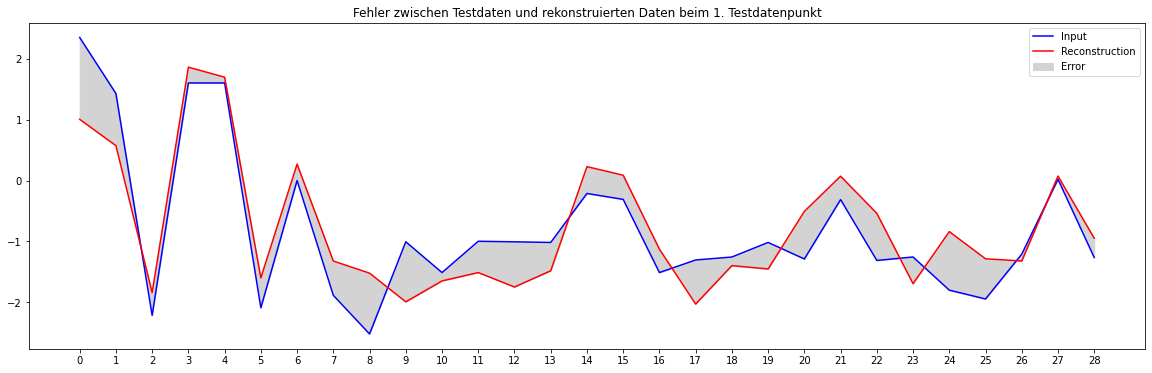

In [99]:
encoded_data = autoencoder.encoder(X_test_ae).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

#fig, ax = plt.subplots()
plt.figure(figsize = (20,6))
plt.plot(X_test_ae[1], 'b')
plt.plot(decoded_data[1], 'r')
plt.fill_between(np.arange(X_test_ae.shape[1]), decoded_data[1], X_test_ae[1], color='lightgray')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.xticks(ticks = np.arange(0, X_test_ae.shape[1], 1))
plt.title("Fehler zwischen Testdaten und rekonstruierten Daten beim 1. Testdatenpunkt")
plt.show()


In [100]:
autoencoder_report = classification_report(y_true = eval_ae.y_real_binary, y_pred = eval_ae.anomalies_found, output_dict = True)

In [101]:
autoencoder_report = pd.DataFrame.from_dict(autoencoder_report).round(4)

autoencoder_report


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.0669,0.9871,0.7658,0.5270,0.9633
recall,0.6224,0.7696,0.7658,0.6960,0.7658
f1-score,0.1208,0.8649,0.7658,0.4929,0.8456
support,3210.0000,120910.0000,0.7658,124120.0000,124120.0000


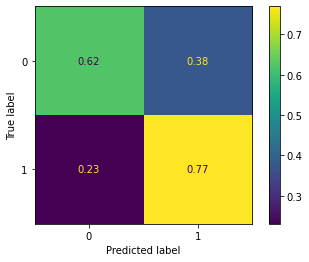

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(eval_ae.y_real_binary, eval_ae.anomalies_found, normalize = "true")).plot()

In [86]:
# Summe an gemeldeten Anomalien pro Feature für alle Datenpunkte aus dem Normalbetrieb (y_true == DeviationID == 1)

np.sum(eval_ae[(eval_ae.y_true == 1)], axis = 0)[:-4]

LevelMainTank      733.0
PI12003_PV_Out       0.0
YC14001_MV          73.0
FIC14002_MV         40.0
FIC14002_PV_Out     11.0
FIC14002_SP          0.0
YC14006_MV           4.0
PI14012_PV_Out      37.0
YC23001_MV          11.0
YC21001_MV          27.0
FIC23002_PV_Out      0.0
FIC23002_MV          5.0
FIC23002_SP          0.0
FIC22002_PV_Out     71.0
FIC22002_SP          0.0
FIC21002_MV         52.0
FIC21002_PV_Out      0.0
FIC21002_SP          0.0
LIC23002_MV          0.0
LIC23002_PV_Out      3.0
LIC22002_MV          1.0
LIC22002_PV_Out     79.0
LIC21002_MV          2.0
LIC21002_PV_Out    204.0
PIC14007_MV         46.0
PIC14007_PV_Out    205.0
PI10003_PV_Out      75.0
step_length         17.0
dtype: float64

In [1980]:
eval_ae[(eval_ae.LIC21002_PV_Out == 1) & (eval_ae.LevelMainTank == 1)].groupby("y_true").sum()

,LevelMainTank,PI12003_PV_Out,YC14001_MV,FIC14002_MV,FIC14002_PV_Out,FIC14002_SP,YC14006_MV,PI14012_PV_Out,YC23001_MV,YC21001_MV,...,LIC22002_PV_Out,LIC21002_MV,LIC21002_PV_Out,PIC14007_MV,PIC14007_PV_Out,PI10003_PV_Out,step_length,pred_anomalies,anomalies_found,y_real_binary
y_true,,,,,,,,,,,,,,,,,,,,,
1.0,29,0,0,0,0,0,0,0,0,0,...,0,0,29,0,0,0,15,80,29,0.0
6.0,298,0,0,5,0,0,102,0,0,176,...,0,234,298,180,0,13,0,1539,298,298.0
7.0,192,0,0,0,0,0,1,0,0,1,...,1,1,192,34,0,2,145,625,192,192.0
8.0,6971,6906,0,0,2079,6906,6969,5293,20,879,...,33,2245,6971,6919,2697,1491,14,65892,6971,6971.0
9.0,61,0,0,0,0,0,0,0,0,0,...,0,2,61,0,0,9,8,152,61,61.0
10.0,55,0,0,0,0,0,0,0,1,1,...,0,1,55,0,0,0,7,162,55,55.0


In [55]:
import matplotlib.pyplot as plt

#a["timestamp"] = a["timestamp"].dt.total_seconds()

import plotly.express as px

px.line(a[(a.batchn == 1)], 
        x = "step_length", 
        y = "PI12002_PV_Out", color = "batchn",
       facet_row = "CuStepNo")


In [54]:
px.line(dtw_df[(dtw_df.batchn == 1)], 
        x = "step_length", 
        y = "PI12002_PV_Out", color = "batchn",
       facet_col = "DeviationID",
       facet_row = "CuStepNo")


In [1884]:
# Füge die vorhergesagten Anomalien zu dem originalen Testdatensatz hinzu für Evaluierungen
eval_test_ae = test_ae.reset_index(drop = True).merge(eval_ae[["y_true", "anomalies_found"]], left_index = True, right_index = True)

In [1886]:
eval_norm = test_ae.reset_index(drop = True)[["batchn", "CuStepNo"]].merge(eval_ae, left_index = True, right_index = True)

In [1887]:
eval_norm[(eval_norm.LevelMainTank == 1) & (eval_norm.y_true == 1)].groupby(["y_true", "batchn", "CuStepNo"]).sum()

LevelMainTank  PI12003_PV_Out  YC14001_MV  \
y_true batchn CuStepNo                                              
1.0    51.0   3.0                   1               0           0   
       53.0   3.0                   3               0           0   
       255.0  1.0                 129               0           0   
              3.0                  99               0           0   
              7.0                  36               0           0   
              8.0                 271               0           0   

                        FIC14002_MV  FIC14002_PV_Out  FIC14002_SP  YC14006_MV  \
y_true batchn CuStepNo                                                          
1.0    51.0   3.0                 0                0            0           0   
       53.0   3.0                 0                0            0           0   
       255.0  1.0                 0                0            0           0   
              3.0                 0                0            0           2   
              7.0                 0                0            0           0   
              8.0                 0                0            0           0   

                        PI14012_PV_Out  YC23001_MV  YC21001_MV  ...  \
y_true batchn CuStepNo                                          ...   
1.0    51.0   3.0                    0           0           0  ...   
       53.0   3.0                    0           0           0  ...   
       255.0  1.0                    0           0           7  ...   
              3.0                    0           0           0  ...   
              7.0                    0           0           5  ...   
              8.0                    0           0           0  ...   

                        LIC22002_PV_Out  LIC21002_MV  LIC21002_PV_Out  \
y_true batchn CuStepNo                                                  
1.0    51.0   3.0                     0            0                0   
       53.0   3.0                     0            0                0   
       255.0  1.0                     0            0               45   
              3.0                     0            0                0   
              7.0                     0            0               36   
              8.0                     0            0                2   

                        PIC14007_MV  PIC14007_PV_Out  PI10003_PV_Out  \
y_true batchn CuStepNo                                                 
1.0    51.0   3.0                 0                0               0   
       53.0   3.0                 0                0               0   
       255.0  1.0                 0                0               0   
              3.0                 0                0               0   
              7.0                 0                0               0   
              8.0                 0                0              30   

                        step_length  pred_anomalies  anomalies_found  \
y_true batchn CuStepNo                                                 
1.0    51.0   3.0                 0               1                1   
       53.0   3.0                 0               3                3   
       255.0  1.0                 6             189              129   
              3.0                 0             107               99   
              7.0                 3              81               36   
              8.0                51             362              271   

                        y_real_binary  
y_true batchn CuStepNo                 
1.0    51.0   3.0                 0.0  
       53.0   3.0                 0.0  
       255.0  1.0                 0.0  
              3.0                 0.0  
              7.0                 0.0  
              8.0                 0.0  

[6 rows x 31 columns]

In [1888]:
eval_ae[(eval_ae.y_true == 3) & (eval_ae.pred_anomalies < 1)]

,LevelMainTank,PI12003_PV_Out,YC14001_MV,FIC14002_MV,FIC14002_PV_Out,FIC14002_SP,YC14006_MV,PI14012_PV_Out,YC23001_MV,YC21001_MV,...,LIC21002_MV,LIC21002_PV_Out,PIC14007_MV,PIC14007_PV_Out,PI10003_PV_Out,step_length,y_true,pred_anomalies,anomalies_found,y_real_binary
4409,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.0,0,False,1.0
4410,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.0,0,False,1.0
4411,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.0,0,False,1.0
4412,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.0,0,False,1.0
4413,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.0,0,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37139,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.0,0,False,1.0
37140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.0,0,False,1.0
37141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.0,0,False,1.0
37142,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.0,0,False,1.0


## Pipelines für die ML-Modelle/ Deployment für Testdaten

## Visualisierungen

In [1889]:
figs = []

# Erstelle für jede unterschiedliche DeviationID ein Plot, das den Verlauf eines bestimmten Werts pro Batch anzeigt

def create_batch_comparisons(data, column):
    n = 0
    for x in sorted(data.DeviationID.unique()):
        fig = px.line(data[(a.batchn == n) & (data.DeviationID == x)],  x = "batch_duration", 
                      y = column, 
                      title = f"DeviationID = {x}"
                 )

        for n in range(batchn): 
            fig.add_scatter(x = data[(data.batchn == n) & (data.DeviationID == x)]["batch_duration"], 
                            y = data[(data.batchn == n) & (data.DeviationID == x)][column])
        figs.append(fig)
        # jedes Element in figs steht für ein Plot mit allen Batches, die die gleiche DeviationID aufweisen
        # Achtung! Die traces in der Farblegende sind: batchn des Batches + 1
    return figs

#gg = create_batch_comparisons(dtw_df, "YC14001_MV")

In [1890]:
#for e in range(0, len(gg)):
#    gg[e].show()
    

In [1891]:
from plotly.subplots import make_subplots

fig_s = []

# Erstelle für jede unterschiedliche DeviationID ein Plot, das den Verlauf eines bestimmten Werts pro Batch anzeigt

def create_step_comparisons(data, column, CuStep):
    n = 0
    
    
    for x in sorted(a.DeviationID.unique()):
        fig = px.line(data[(data.batchn == n) & (data.DeviationID == x)],  x = "step_length", 
                      y = column, 
                      title = f"DeviationID = {x}, StepID: {CuStep}", hover_name = "batchn",
                 )
        for n in range(1, batchn + 1):
            fig.add_scatter(x = data[(data.batchn == n) & (data.DeviationID == x) & (data.CuStepNo == CuStep)]["step_length"], 
                            y = data[(data.batchn == n) & (data.DeviationID == x) & (data.CuStepNo == CuStep)][column],
                            )
        fig_s.append(fig)
        # jedes Element in figs steht für ein Plot mit allen Batches, die die gleiche DeviationID aufweisen
        # Achtung! Die traces in der Farblegende sind: batchn des Batches + 1
    return fig_s

#gg_s = create_step_comparisons(a, "PI12002_PV_Out", 8)

In [1892]:
#for e in range(0, len(gg_s)):
#    gg_s[e].show()
    

In [1893]:
#a[(a.CuStepNo == 8) & (a.batchn != 21)].step_length.describe()

In [1894]:
#dtw_df[dtw_df.batchn.isin([72, 75, 73])].DeviationID.unique()